In [1]:
import sys

project_root = "/home/20230765/src"
if project_root not in sys.path:
    sys.path.append(project_root)

import json
import numpy as np
from redi.pipeline_re_sd import ReSDPipeline
import torch
import h5py
import matplotlib.pyplot as plt

In [2]:
trajectory_path = "../data/generated_data/trajectories.h5"

num_trajectories = 2000

np.random.seed(42)
query_set = np.random.choice(np.arange(0, num_trajectories), size=200, replace=False)
key_set = list(set(np.arange(0, num_trajectories)) - set(query_set))

In [3]:
prompts_to_path = "../data/reference_knowledge_base/prompts.json"
prompts = json.load(open(prompts_to_path, "r"))

In [4]:
pipe = ReSDPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda:0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
with open("../data/results/neighbours_key-margin=0_dataset-size=2000.json") as f:
    dim_neighbours = json.load(f)

In [6]:
with h5py.File(trajectory_path, "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())

In [7]:
value_margin_steps = 20
config_index = 3
query_index = 109
neighbour_num = 0

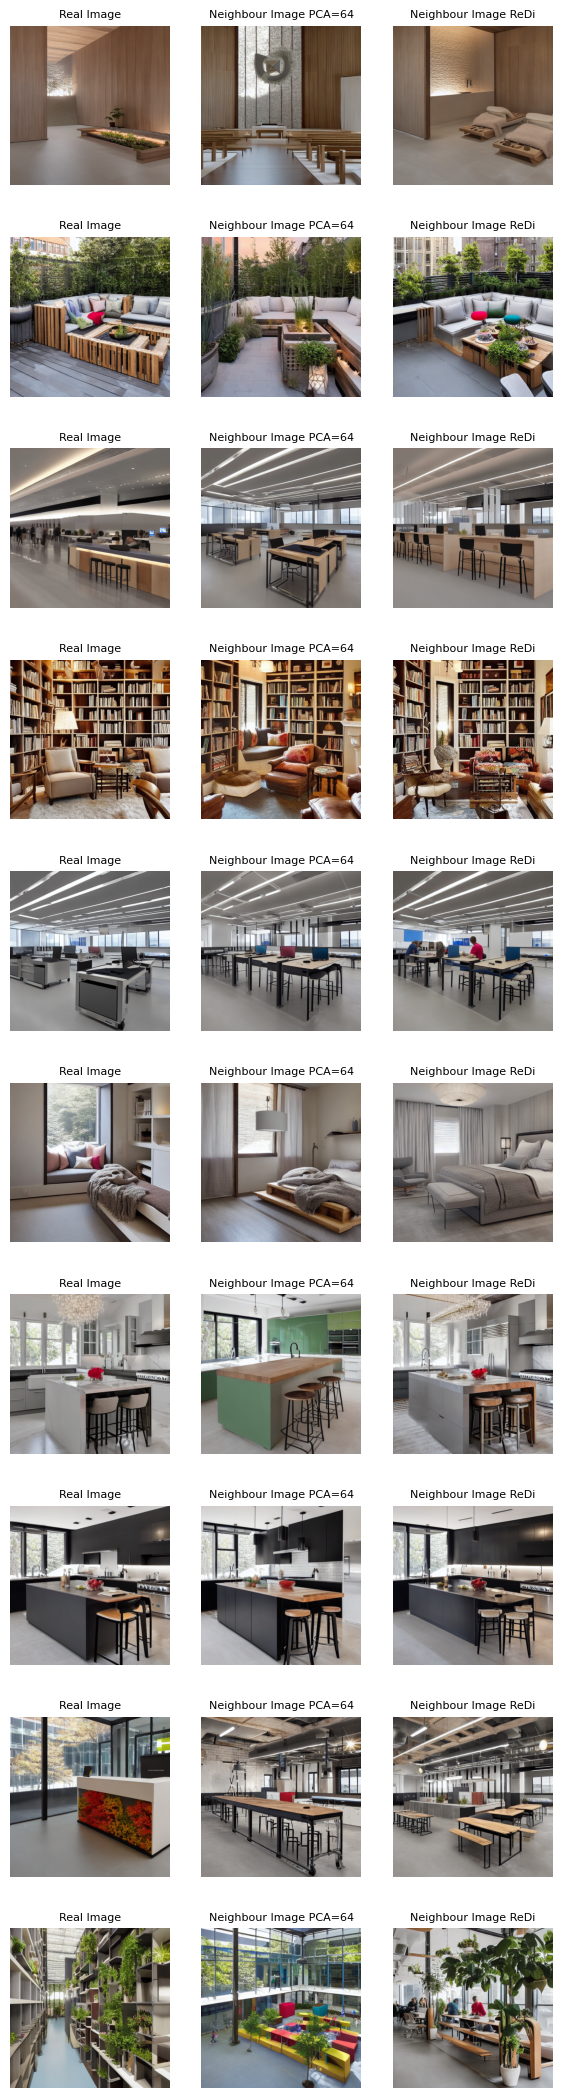

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(7, 3 * 9))
num = 0
for i in np.random.choice(np.arange(0, 200), size=100, replace=False):
    query_index = i
    neighbours_config = dim_neighbours[config_index][query_index]
    neighbours_reference = dim_neighbours[-1][query_index]
    if neighbours_config[neighbour_num] != neighbours_reference[neighbour_num]:
        with h5py.File(trajectory_path, "r") as trajectory_file:
            last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
            last_neighbour_latent = trajectory_file[
                traj_names[neighbours_config[neighbour_num]]
            ][-1]
            last_neighbour_reference_latent = trajectory_file[
                traj_names[neighbours_reference[neighbour_num]]
            ][-1]

        # plot 3 images
        img_real = pipe.decode_latent_to_image(latent=last_real_latent)
        img_neighbour = pipe.decode_latent_to_image(latent=last_neighbour_latent)
        img_neighbour_reference = pipe.decode_latent_to_image(
            latent=last_neighbour_reference_latent
        )

        ax[num][0].imshow(img_real)
        ax[num][0].set_title("Real Image", fontsize=8)
        ax[num][1].imshow(img_neighbour)
        ax[num][1].set_title("Neighbour Image PCA=64", fontsize=8)
        ax[num][2].imshow(img_neighbour_reference)
        ax[num][2].set_title("Neighbour Image ReDi", fontsize=8)
        ax[num][0].axis("off")
        ax[num][1].axis("off")
        ax[num][2].axis("off")
        num += 1
        if num == 10:
            break
plt.show()